In [1]:
from copy import copy
from time import time

import matplotlib.pyplot as plt
import pandas as pd

from HARK.Calibration.Income.IncomeTools import (
    CGM_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.ConsumptionSaving.ConsIndBequestModel import (
    TerminalBequestConsumerType,
    init_lifecycle,
)
from HARK.datasets.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.datasets.SCF.WealthIncomeDist.SCFDistTools import income_wealth_dists_from_scf
from HARK.utilities import plot_funcs

In [2]:
birth_age = 25
death_age = 90
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to, age=birth_age, education=education, wave=1995
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True, cross_sec=True, year=2004, min_age=birth_age, max_age=death_age - 1
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_lifecycle)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params.update({"LivPrb": [1.0] * len(liv_prb)})

In [3]:
# Make and solve an idiosyncratic shocks consumer with a finite lifecycle
LifecycleExample = TerminalBequestConsumerType(**params)
# Make this consumer live a sequence of periods exactly once
LifecycleExample.cycles = 1

In [4]:
start_time = time()
LifecycleExample.solve()
end_time = time()
print(f"Solving a lifecycle consumer took {end_time - start_time} seconds.")
LifecycleExample.unpack("cFunc")

Solving a lifecycle consumer took 0.18243980407714844 seconds.


Consumption functions while retired:


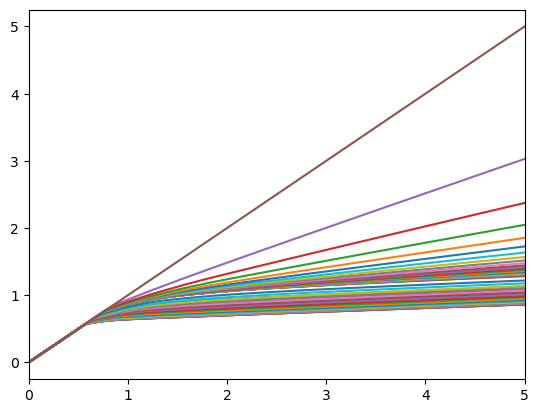

In [5]:
# Plot the consumption functions
print("Consumption functions while retired:")
plot_funcs(LifecycleExample.cFunc, 0, 5)

In [6]:
# Number of LifecycleExamples and periods in the simulation.
LifecycleExample.AgentCount = 500
LifecycleExample.T_sim = 200

# Set up the variables we want to keep track of.
LifecycleExample.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm"]

# Run the simulations
LifecycleExample.initialize_sim()
LifecycleExample.simulate()

{'aNrm': array([[0.29091572, 0.97245075, 0.35935722, ..., 1.79086226, 2.87066564,
         0.24390107],
        [0.24042997, 0.97210826, 0.64190419, ..., 1.74137061, 1.85673772,
         0.14786912],
        [0.61367842, 1.91209797, 0.62872708, ..., 1.4271    , 2.64166517,
         0.97441874],
        ...,
        [2.56191579, 0.23354436, 0.23587319, ..., 0.51659251, 5.04871004,
         0.44522969],
        [3.00621224, 0.22403038, 0.43095048, ..., 1.0118785 , 5.00798932,
         0.38611808],
        [3.62557585, 0.39295056, 0.75678264, ..., 2.19955431, 3.24802599,
         0.45885516]]),
 'cNrm': array([[0.83190416, 0.93440997, 0.85056638, ..., 0.99750512, 1.06915329,
         0.81642578],
        [0.80529055, 0.91823939, 0.88512018, ..., 0.97523641, 0.98301967,
         0.76686004],
        [0.87217394, 0.97243575, 0.87402316, ..., 0.94040405, 1.01814939,
         0.90705168],
        ...,
        [1.01325125, 0.79710812, 0.79793768, ..., 0.85943915, 1.15972704,
         0.8483509

In [7]:
raw_data = {
    "Age": LifecycleExample.history["t_age"].flatten() + birth_age - 1,
    "pIncome": LifecycleExample.history["pLvl"].flatten(),
    "nrmM": LifecycleExample.history["mNrm"].flatten(),
    "nrmC": LifecycleExample.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

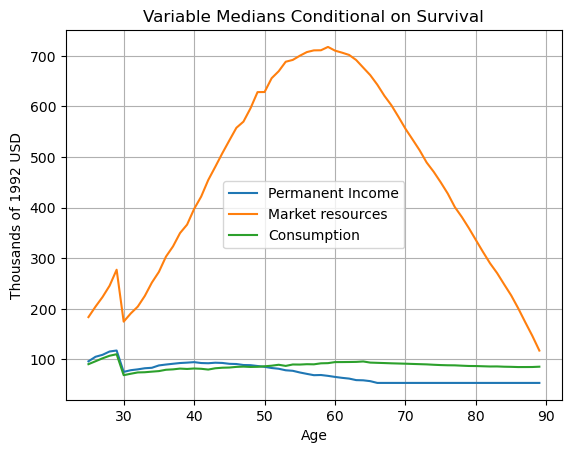

In [8]:
# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Thousands of {} USD".format(adjust_infl_to))
plt.title("Variable Medians Conditional on Survival")
plt.grid()